## Example: The Darcy flow equation

In this example, the Darcy flow equation is used to model single phase fluid flow through a porous medium. Given an input permeability field, $ a(x) $, and the forcing function, $f(x)$, the output pressure flow $u(x)$ can be calculated using the following equation:
$$
-\nabla\cdot(a(x)\nabla u(x)) = f(x) \qquad x \in (0,1)^2
$$
With Dirchlet boundary conditions: 
$$
u(x) = 0 \qquad x\in \partial(0,1)^2
$$
For this example, the forcing function $f(x) = 1$. 

First, lets import the relevant utilities.

In [3]:
import math
from devito import div, grad, Eq, Operator, TimeFunction, Function, solve, Grid, configuration, initialize_function
import numpy as np
import numpy.fft as fft
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Set a random seed for reproducibility:

In [4]:
np.random.seed(42)

This is the class used to define a Gaussian random field for the input:

In [5]:
# Code edited from  https://github.com/zongyi-li/fourier_neural_operator/blob/master/data_generation/navier_stokes/random_fields.py
class GaussianRF(object):

    def __init__(self, dim, size, alpha=2, tau=3, sigma=None, boundary="periodic"):

        self.dim = dim

        if sigma is None:
            sigma = tau**(0.5*(2*alpha - self.dim))

        k_max = size//2

        if dim == 2:
            wavenumers = (np.concatenate((np.arange(0, k_max, 1), \
                                    np.arange(-k_max, 0, 1)),0))
            wavenumers = np.tile(wavenumers, (size,1))

            k_x = wavenumers.transpose(1,0)
            k_y = wavenumers

            self.sqrt_eig = (size**2)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0] = 0.0

        self.size = []
        for j in range(self.dim):
            self.size.append(size)

        self.size = tuple(self.size)

    def sample(self, N):

        coeff = np.random.randn(N, *self.size)
        coeff = self.sqrt_eig * coeff
        

        return fft.ifftn(coeff).real

Next, lets declare the variables to be used and create a grid for the functions:

In [6]:
# Silence the runtime performance logging
configuration['log-level'] = 'ERROR'

# Number of grid points on [0,1]^2 
s = 256

# Create s x s grid with spacing 1
grid = Grid(shape=(s, s), extent=(1.0,1.0))

x, y = grid.dimensions
t = grid.stepping_dim

Here we produce input data to be used as permeability samples. First, the Gaussian random field class is called, then a threshold is introduced, where anything less than 0 is 4 and values above or equal to 0 is 12. This produces permeability samples similar to real world applications. We will create three different inputs.

In [7]:
# Set up 2D GRF with covariance parameters to generate random coefficients
norm_a = GaussianRF(2, s, alpha=2, tau=3)

# Sample random fields
# Create a threshold, either 4 or 12 (common for permeability)
thresh_a = norm_a.sample(3)
thresh_a[thresh_a>=0] = 12
thresh_a[thresh_a<0] = 4

# The inputs:
w1 = thresh_a[0]
w2 = thresh_a[1]
w3 = thresh_a[2]

Plotting the inputs:

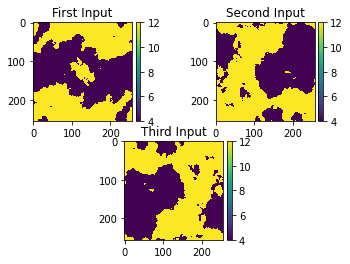

In [8]:
#NBVAL_IGNORE_OUTPUT
# Plot to show the input:
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)
im1 = ax1.imshow(w1, interpolation='none')
im2 = ax2.imshow(w2, interpolation='none')
im3 = ax3.imshow(w3, interpolation='none')
ax1_divider = make_axes_locatable(ax1)
ax2_divider = make_axes_locatable(ax2)
ax3_divider = make_axes_locatable(ax3)
cax1 = ax1_divider.append_axes("right", size="5%", pad=0.05)
cax2 = ax2_divider.append_axes("right", size="5%", pad=0.05)
cax3 = ax3_divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
plt.colorbar(im2, cax=cax2)
plt.colorbar(im3, cax=cax3)
ax1.title.set_text('First Input')
ax2.title.set_text('Second Input')
ax3.title.set_text('Third Input')
plt.show()

There is no time dependence for this equation, so $ a $ and $ f $ are defined as `function` objects, however the output $u$ is defined as a `Timefunction` object in order to implement a pseudo-timestepping loop, using `u` and `u.forward` as alternating buffers. 

In [9]:
# Forcing function, f(x) = 1 
f = np.ones((s, s))

# Create function on grid
# Space order of 2 to enable 2nd derivative
# TimeFunction for u can be used despite the lack of a time-dependence. This is done for psuedotime
u = TimeFunction(name='u', grid=grid, space_order=2)
a = Function(name='a', grid=grid, space_order=2)
f1 = Function(name='f1', grid=grid, space_order=2)

Define the equation using symbolic code:

In [10]:
# Define 2D Darcy flow equation
# Staggered FD is used to avoid numerical instability
equation_u = Eq(-div(a*grad(u,shift=.5),shift=-.5),f1)

SymPy creates a stencil to reorganise the equation based on `u`, but when creating the update expression, `u.forward` is used in order to stop `u` being overwritten:

In [11]:
# Let SymPy solve for the central stencil point
stencil = solve(equation_u, u)

# Let our stencil populate the buffer `u.forward`
update = Eq(u.forward, stencil)

Define the boundary conditions and create the operator:

In [12]:
# Boundary Conditions
nx = s
ny = s
bc = [Eq(u[t+1, 0, y],u[t+1, 1,y])]  # du/dx = 0 for x=0.
bc += [Eq(u[t+1,nx-1, y],u[t+1,nx-2, y])]  # du/dx = 0 for x=1.
bc += [Eq(u[t+1, x, 0],u[t+1,x ,1])]  # du/dx = 0 at y=0
bc += [Eq(u[t+1, x, ny-1],u[t+1, x, ny-2])]  # du/dx=0 for y=1
# u=0 for all sides
bc += [Eq(u[t+1, x, 0], 0.)]
bc += [Eq(u[t+1, x, ny-1], 0.)]
bc += [Eq(u[t+1, 0, y], 0.)]
bc += [Eq(u[t+1, nx-1, y], 0.)]

op = Operator([update] + bc)

This function is used to call an operator to generate each output:

In [13]:
'''
Function to generate 'u' from 'a' using Devito

parameters 
-----------------
perm: Array of size (s, s)
    This is "a"
f: Array of size (s, s)
    The forcing function f(x) = 1
 '''
def darcy_flow_2d(perm, f):
    
    # a(x) is the coefficients
    # f is the forcing function
    # initialize a, f with inputs permeability and forcing
    f1.data[:] = f[:]
    initialize_function(a, perm, 0)
    
    # call operator for the 15,000th pseudo-timestep
    op(time= 15000)
   
    return np.array(u.data[0])

Generate the outputs:

In [14]:
# Call operator for the 15,000th psuedo-timestep
output1 = darcy_flow_2d(w1, f)
output2 = darcy_flow_2d(w2, f)
output3 = darcy_flow_2d(w3, f)

Use an assert on the norm of the results in order to confirm they are what is expected:

In [15]:
assert np.isclose(LA.norm(output1),1.0335084, atol=1e-3, rtol=0)
assert np.isclose(LA.norm(output2),1.3038709, atol=1e-3, rtol=0)
assert np.isclose(LA.norm(output3),1.3940924, atol=1e-3, rtol=0)

Plot the output:

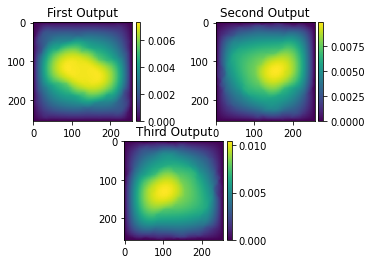

In [16]:
#NBVAL_IGNORE_OUTPUT
# plot to show the output: 
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)
im1 = ax1.imshow(output1, interpolation='none')
im2 = ax2.imshow(output2, interpolation='none')
im3 = ax3.imshow(output3, interpolation='none')
ax1_divider = make_axes_locatable(ax1)
ax2_divider = make_axes_locatable(ax2)
ax3_divider = make_axes_locatable(ax3)
cax1 = ax1_divider.append_axes("right", size="5%", pad=0.05)
cax2 = ax2_divider.append_axes("right", size="5%", pad=0.05)
cax3 = ax3_divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)
plt.colorbar(im2, cax=cax2)
plt.colorbar(im3, cax=cax3)
ax1.title.set_text('First Output')
ax2.title.set_text('Second Output')
ax3.title.set_text('Third Output')
plt.show()

This output shows the flow of pressure given the permeability sample seen above. The results are as expected as a higher pressure is seen in the largest area that contains the lower permeability of 4.